 # Three Au NP
 In this notebook we calculate the the optical spectra and scattering pattern of a symmetric Au dimer.The notebook is structured as follows:
 *  **Importing the libraries:** setup of useful settings and import of necessary libraries and databases.
 *  **Setting up the inputs:** definition of the inputs of the simulation.
 *  **Performing the calculations**: call to py_gmm to compute all the relevant far-field quantities.
 *  **Plotting the results**: plot of cross-section and radiation pattern
 
 In order to run the notebook Plotly library is needed. It can be installed with the following command (preferred):
 ```
 conda install -c https://conda.anaconda.org/plotly plotly
 ```
 or in alternative
 ```
 pip install plotly
```
Just one final thing: launch this notebook with the `--NotebookApp.iopub_data_rate_limit=1.0e10` option, or it will fail

# Importing the libraries

In [1]:
#------Library loading------

# numpy for matrix computations
import numpy as np; import numpy.ma as ma

# system libraries
import sys

# plotting libraries
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.patches import Circle, Ellipse

# Generalized Multiparticle Mie import
sys.path.append('../')
import py_gmm

# plotly
from plotly import __version__
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

print(__version__) # requires version >= 1.9.0

3.8.1


# Setting up the inputs

### Target inputs (optical constant database, sphere coordinates, composition and size)

In [2]:
# building the optical constant database
eps_db_out=py_gmm.mat.generate_eps_db('../epsilon/',ext='*.edb')
eps_files,eps_names,eps_db=eps_db_out['eps_files'],eps_db_out['eps_names'],eps_db_out['eps_db']

# sphere radius (in nm)
v_r = np.array([ 15., 5., 5.])

# sphere position (in nm)
m_xyz = np.array([[  0,    0. ,   0. ],
                  [  30,   30. ,   0. ],
                  [  60,  0. ,   0. ]])

# how many spheres in the target? We guess it from he length of the radius vector
ns = len(v_r)

# sphere composition, calling the names contained in "eps_names", just populated above
target_comp= np.array(3*['eAuJCSTDf']) # vector containing the optical constants names

# colours for the plots:
v_col = 3*['#FFD700']

# refractive index of the environment
n_matrix = 1.33  # water

### Plane wave incident field

In [3]:
# Euler angles: (alpha,beta,gamma)=(0,0,0) means a z-directed, x-polarized plane wave
alpha = 0.0   # azimuth
beta = 0.0  # polar
gamma = 0.0  # polarization

# Wavelengths for the specrum computation
wl_min = 300
wl_max = 800
n_wl = 250
v_wl = np.linspace(wl_min,wl_max,n_wl)

# Wavelength for the far field computation
v_wl_lf = [530.0,650] # resonance wavelengths

### Additional inputs for the simulation

In [4]:
n_stop=3 # maximum multipolar expansion order
f_int=0.0; # interaction cutoff (normally set to zero to have full interactions)
lf_ratio=300; # plot sphere local field contribution up to a distance equal to d=lf_ratio*r_sphere
qs_flag='no' # retarded simulation

### 2D Target plot

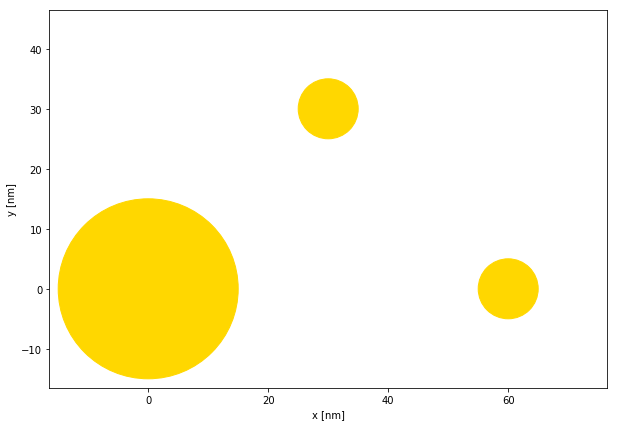

In [5]:
# target plot
fig = plt.figure(num=1,figsize=(10,10)) # setting the figure size
ax = fig.add_subplot(1, 1, 1, aspect='equal')  # creating the plotting axis

# plot bounds and eliminating x and y ticks
plt.xlim(-(m_xyz[:,0].min()+1.1*v_r.max()),(m_xyz[:,0].max()+1.1*v_r.max()))
plt.ylim(-(m_xyz[:,1].min()+1.1*v_r.max()),(m_xyz[:,1].max()+1.1*v_r.max()))
plt.xlabel('x [nm]')
plt.ylabel('y [nm]')


# plotting the target
for c,r,col in zip(m_xyz,v_r,v_col):
    c0=c[0];c1=c[1];
    ax.add_patch(Circle((c0,c1),r,color=col))

### 3D Target plot

In [6]:
def sphericalSurfacePlotCoordinates(radius,center_xyz,npoints):
    # Parametrical definition of a spherical surface in 3d:
    u = np.linspace(0, 2 * np.pi, npoints) # longitude
    v = np.linspace(0, np.pi, npoints) # colatitude
    
    # Coordinates:
    x = radius * np.outer(np.cos(u), np.sin(v)) + center_xyz[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center_xyz[1];
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) +center_xyz[2];
    
    return x,y,z

data = []
definition = 50

for i in range(len(v_r)):
    x, y, z = sphericalSurfacePlotCoordinates(v_r[i],m_xyz[i,:],definition)
    surface = go.Surface(x=x,y=y,z=z,colorscale=[[0,v_col[i]], [1, v_col[i]]],showscale=False,name='nanoparticle '+str(i))
    data.append(surface)
    
layout = go.Layout(
    title='Parametric Plot',
    scene=dict(
        aspectmode='data',
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3D target plot')

## Performing the calculations

### Scattering cross sections and field expansion coefficients for the spectral computation

In [7]:
# computing the expansion coefficients and cross sections with a loop
m_abcd_ext_sca_abs = []  # list to be filled with the output
for wl in v_wl:
    
    # retrieving optical constants at wl from the database
    e_list=py_gmm.mat.db_to_eps(wl,eps_db,target_comp);
    m_eps=np.column_stack((np.real(e_list),np.imag(e_list)));
    
    # solving the gmm problem (calculating the cross sections and the expansion coefficients)
    out=py_gmm.gmm_py.gmm_f2py_module.expansion_coefficients(m_xyz, # target sphere position in nm
                                                      v_r,   # target sphere radii in nm
                                                      m_eps, # e1 and e2 for each sphere
                                                      f_int,  # interaction coefficient
                                                      n_matrix, # environment refractive index
                                                      wl, # computation wavelength
                                                      alpha,beta,gamma, # euler angles for the incident pw
                                                      n_stop, # maximum number for expansion coefficients
                                                      qs_flag) # quasi static approximation
    m_abcd_ext_sca_abs.append(out)
    
# extracting coefficients and cross section
v_coeff=[];v_cext=[];v_csca=[];v_cabs=[];
for out in m_abcd_ext_sca_abs:
    v_coeff.append(out[0]);
    v_cext.append(out[1]);
    v_csca.append(out[2]);
    v_cabs.append(out[3]);

# converting the lists to numpy arrays
v_coeff=np.array(v_coeff)
v_cext=np.array(v_cext)
v_csca=np.array(v_csca)
v_cabs=np.array(v_cabs)

### Scattered field

In [8]:
# local field for the first resonance
v_far = []
for wl_lf in v_wl_lf:

    # optical constants
    e_list=py_gmm.mat.db_to_eps(wl_lf,eps_db,target_comp);
    m_eps=np.column_stack((np.real(e_list),np.imag(e_list)));

    # gmm coefficients computation
    out=py_gmm.gmm_py.gmm_f2py_module.expansion_coefficients(m_xyz,  # target sphere position in nm
                                                             v_r,  # target sphere radii in nm
                                                             m_eps,  # e1 and e2 for each sphere
                                                             f_int,  # interaction coefficient
                                                             n_matrix,  # environment refractive index
                                                             wl_lf, # computation wavelength
                                                             alpha,beta,gamma,  # euler angles for the incident pw
                                                             n_stop,  # maximum number for expansion coefficients
                                                             qs_flag)  # quasi static approximation
    v_amnbmn=out[0][:,0] # getting field expansion coefficients
    v_dmncmn=out[0][:,1]

    # local field
    v_emn=py_gmm.gmm_py.gmm_f2py_module.emn(n_stop)[0] # normalization coeffs

    # retrieving the scattered cloud
    k_far = 2.0*np.pi*n_matrix/wl_lf
    m_sc, scatot, error = py_gmm.gmm_py.gmm_f2py_module.efar(k_far,
                                                             n_stop,
                                                             0.0,3.6e2,360,
                                                             180,
                                                             0.0,
                                                             v_amnbmn,
                                                             m_xyz)
    v_far.append(m_sc)

# Plotting the results

### Extinction cross section

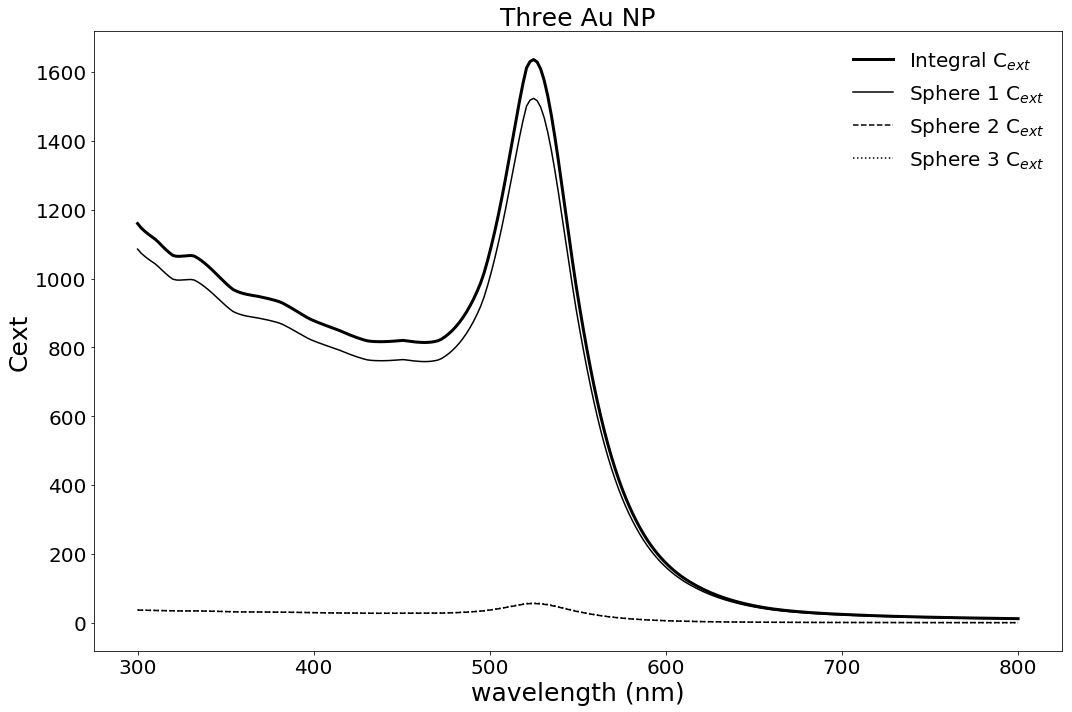

In [9]:
# cross section plot
f_size=25;
f_size_ticks=20;
plt.figure(1,figsize=(15,10));
plt.plot(v_wl,np.sum(v_cext,axis=1),'k',linewidth=3.0);
plt.plot(v_wl,v_cext[:,0],'k',
         v_wl,v_cext[:,1],'k--',
         v_wl,v_cext[:,2],'k:');

# plt title
plt.title('Three Au NP',fontsize=f_size)

# axes labels
plt.xlabel(r'wavelength (nm)', fontsize=f_size)
plt.ylabel(r'Cext', fontsize=f_size)

# ticks
plt.xticks(fontsize=f_size_ticks)
plt.yticks(fontsize=f_size_ticks)

# legend
plt.legend((r'Integral C$_{ext}$',
            r'Sphere 1 C$_{ext}$',
            r'Sphere 2 C$_{ext}$',
            r'Sphere 3 C$_{ext}$'),frameon=False,fontsize=f_size-5)

# layout
plt.tight_layout()